In [7]:
import shapefile
import numpy as np
import xarray as xr
from shapely.geometry import mapping as mappy
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import cartopy
import os, sys
import pandas as pd
import richdem as rd
import skimage
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from skimage import measure
from skimage import util
from skimage import morphology
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction

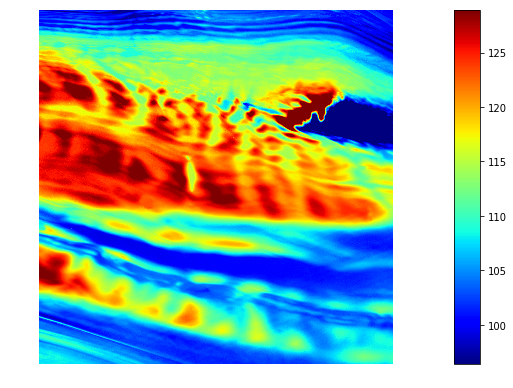

In [3]:
tiffname = '38_49_8m_dem.tif'
metadata = '38_49_8m_dem_meta.txt'
DEM = rd.rdarray(xr.open_rasterio(tiffname),no_data = -9999)
DEMflat = DEM.squeeze()
DEMfig = rd.rdShow(DEMflat[6249:-1,6249:-1], ignore_colours=[0], axes=False, cmap='jet', figsize=(8,5.5))

In [107]:
geoDEM = xr.open_rasterio(tiffname)
geoDEM

<xarray.DataArray (band: 1, y: 12500, x: 12500)>
[156250000 values with dtype=float32]
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 8e+05 8e+05 8e+05 8e+05 ... 7e+05 7e+05 7e+05 7e+05
  * x        (x) float64 1.8e+06 1.8e+06 1.8e+06 ... 1.9e+06 1.9e+06 1.9e+06
Attributes:
    transform:   (8.0, 0.0, 1800000.0, 0.0, -8.0, 800000.0)
    crs:         EPSG:3031
    res:         (8.0, 8.0)
    is_tiled:    0
    nodatavals:  (-9999.0,)

In [109]:
from pyproj import Proj, transform

inProj = Proj(init= geoDEM.crs)
outProj = Proj(init='epsg:4326') #Plate Carree
x2,y2 = transform(inProj,outProj,list(geoDEM.x),list(geoDEM.y))
lat, lon = np.meshgrid(y2,x2)
latmesh = np.array([[lat],]*len(lat))
lonmesh = np.array([[lon],]*len(lat)).transpose()

MemoryError: 

In [4]:
DEMflat_ss = DEMflat[6249:-1,6249:-1]

In [4]:
import time
start=time.time()
#DEM40 = skimage.transform.resize(DEMflat_ss, (DEMflat_ss.shape[0] / 5, DEMflat_ss.shape[1] / 5),
                      #anti_aliasing=True)
#DEM40 = rd.rdarray(DEM40,no_data = -9999 )
DEMf = rd.FillDepressions(DEMflat)
lakes = DEMf-DEMflat
end = time.time()
print(end-start)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
36.27514839172363


In [ ]:
fig_diff = rd.rdShow(lakes, ignore_colours=[0], axes=False, cmap='jet', figsize=(8,5.5))

## Julian's Code

In [7]:
start = time.time()
# 5m meter lakes
DEM40 = skimage.transform.resize(DEMflat, (DEMflat.shape[0] / 10, DEMflat.shape[1] / 10),
                      anti_aliasing=True)
DEM_inv = skimage.util.invert(DEM40)
DEMinv_gaus = gaussian_filter(DEM_inv,1)
marker = np.copy(DEMinv_gaus)
marker[1:-1, 1:-1] = -9999

Inan = np.argwhere(np.isnan(DEMinv_gaus))
Inan_mask = np.isnan(DEMinv_gaus)
Inan_mask_not = np.logical_not(Inan_mask)
if((np.array(Inan)).size>0):
    I = skimage.morphology.binary_dilation(Inan_mask,np.ones(3)) & Inan_mask_not
    marker[I] = DEMinv_gaus[I]
    
mask = DEMinv_gaus
demfs = reconstruction(marker, mask, method='dilation')    

D = DEMinv_gaus-demfs
index = list(Inan_mask_not)


maxdepth = 40
while np.any(D[index]>maxdepth):
    lakemask = D>0
    label_lakemask = measure.label(lakemask)
    STATS = measure.regionprops(label_lakemask,D)

    for r in np.arange(0,len(STATS)):
        if(STATS[r].max_intensity < maxdepth):
            pass
        else:
            poly_x = STATS[r].coords[:,0]
            poly_y = STATS[r].coords[:,1]
            poly = D[poly_x, poly_y]
            ix = poly.argmax()
            #ix = ix[1]
            marker[STATS[r].coords[ix][0],STATS[r].coords[ix][1]] = DEMinv_gaus[STATS[r].coords[ix][0],STATS[r].coords[ix][1]]
    demfs = reconstruction(marker,DEMinv_gaus, method='dilation');
    D   = DEMinv_gaus-demfs;

demfs = skimage.util.invert(demfs)
demfs[Inan_mask] = np.nan
end = time.time()

In [8]:
print(end-start)

4.819223403930664


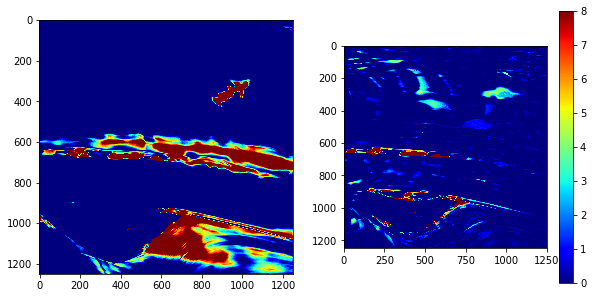

In [55]:
fig, ax = plt.subplots(ncols = 2, figsize=(10,5))
lakes2 = demfs-DEM40
jjscodefig = ax[0].imshow(lakes2, cmap='jet')
jjscodefig.set_clim(0,8)
plt.colorbar(jjscodefig)

basecodefig = ax[1].imshow(lakes, cmap='jet')
basecodefig.set_clim(0,8)


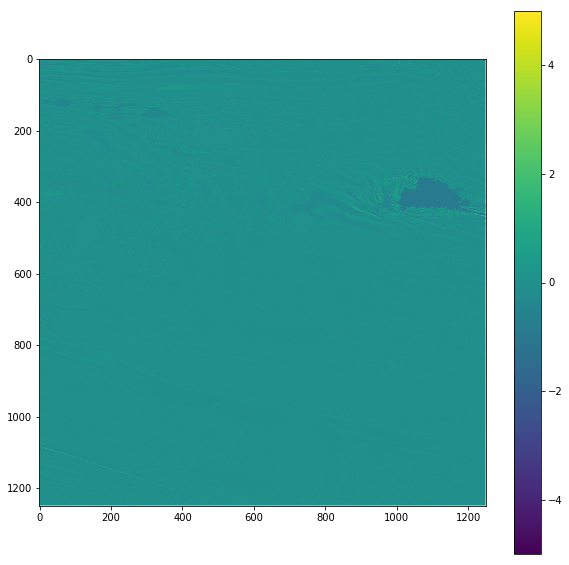

In [10]:
#difference between methods
lakediff = lakes-lakes2
fig, ax = plt.subplots( figsize=(10,10))
plt.imshow(lakediff)
plt.colorbar()
plt.clim(-5,5)

Lake Properties

In [5]:
lakemask = lakes>0
label_lakes = measure.label(lakemask)
LakeProps = measure.regionprops(label_lakes,lakes)

In [11]:
numLakes = len(LakeProps)
Area = np.zeros((numLakes,1))
Orientation= np.zeros((numLakes,1))
Volume = np.zeros((numLakes,1))
Max_Depth = np.zeros((numLakes,1))
Mean_Depth = np.zeros((numLakes,1))
Min_Depth = np.zeros((numLakes,1))
Perimeter = np.zeros((numLakes,1))
PPscore = np.zeros((numLakes,1))
DVscore = np.zeros((numLakes,1))
Centroid = np.zeros((numLakes,2))


In [12]:
for lake in np.arange(0,numLakes):
    Area[lake] = LakeProps[lake].area*8**2
    Orientation[lake] = LakeProps[lake].orientation
    Volume[lake] = LakeProps[lake].intensity_image.sum()*8**2
    Max_Depth[lake] = LakeProps[lake].max_intensity
    Mean_Depth[lake] = LakeProps[lake].mean_intensity
    Min_Depth[lake] = LakeProps[lake].min_intensity
    Perimeter[lake] = LakeProps[lake].perimeter*8
    PPscore[lake] = (4*3.14*Area[lake])/(Perimeter[lake]**2)
    DVscore[lake] = 3*Mean_Depth[lake]/Max_Depth[lake]
    Centroid[lake] = LakeProps[lake].centroid

C:\Users\Julian Spergel\Anaconda3\envs\geo_scipy\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


(0, 5)

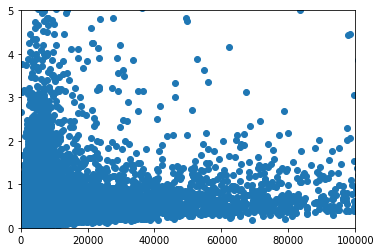

In [13]:
plt.scatter(Area, Max_Depth)
plt.xlim(0,1e5)
plt.ylim(0,5)

## Elevation Data

In [23]:
ElevationProps = measure.regionprops(label_lakes,DEM40)

In [24]:
numLakes = len(LakeProps)
Max_Elev = np.zeros((numLakes,1))
Mean_Elev = np.zeros((numLakes,1))
Min_Elev = np.zeros((numLakes,1))
for lake in np.arange(0,numLakes):
    Max_Elev[lake] =ElevationProps[lake].max_intensity
    Mean_Elev[lake] = ElevationProps[lake].mean_intensity
    Min_Elev[lake] = ElevationProps[lake].min_intensity

array([  53.36597206, 1037.63858631])

## Full Tiles

In [88]:
xlength = DEMflat.shape[0]
ylength = DEMflat.shape[1]
quarter_tile = np.empty([int(xlength/2),int(ylength/2),4])

inProj = Proj(init= geoDEM.crs)
outProj = Proj(init='epsg:4326') #Plate Carree
lon,lat = transform(inProj,outProj,list(geoDEM.x),list(geoDEM.y))


quarter_tile[:,:,0] = DEMflat[0:int(xlength/2), 0:int(ylength/2)]
quarter_tile[:,:,1] = DEMflat[int(xlength/2):xlength,0:int(ylength/2)]
quarter_tile[:,:,2] = DEMflat[0:int(xlength/2),int(ylength/2):ylength]
quarter_tile[:,:,3] = DEMflat[int(xlength/2):xlength,int(ylength/2):ylength]

#coordinates_lat = np.empty([int(xlength/2),4])
#coordinates_lon = np.empty([int(ylength/2),4])

#coordinates_lon[:,0] = lon[0:int(xlength/2)]
#coordinates_lon[:,1] = lon[int(xlength/2):xlength]
#coordinates_lon[:,2] = lon[0:int(xlength/2)]
#coordinates_lon[:,3] = lon[int(xlength/2):xlength]
#coordinates_lat[:,0] = lat[0:int(ylength/2)]
#coordinates_lat[:,1] = lat[0:int(ylength/2)]
#coordinates_lat[:,2] = lat[int(ylength/2):ylength]
#coordinates_lat[:,3] = lat[int(ylength/2):ylength]


In [96]:
numLakes_total = 0
Area_total = []
Orientation_total= []
Volume_total = []
Max_Depth_total = []
Mean_Depth_total = []
Min_Depth_total = []
Perimeter_total = []
PPscore_total = []
DVscore_total = []
Max_Elev_total = []
Mean_Elev_total = []
Min_Elev_total = []
Centroidlat_total = []
Centroidlon_total = []

for tile in np.arange(0,3):
    
    DEM40 = skimage.transform.resize(quarter_tile[:,:,tile], (quarter_tile[:,:,tile].shape[0] / 5, 
                                                              quarter_tile[:,:,tile].shape[1] / 5), anti_aliasing=True)
    DEM40 = rd.rdarray(DEM40,no_data = -9999 )
    DEMf = rd.FillDepressions(DEM40)
    lakes = DEMf-DEM40


    lakemask = lakes>0
    label_lakes = measure.label(lakemask)
    LakeProps = measure.regionprops(label_lakes,lakes)
    ElevationProps = measure.regionprops(label_lakes,DEM40)
    numLakes = len(LakeProps)
    Area = np.zeros((numLakes,1))
    Orientation= np.zeros((numLakes,1))
    Volume = np.zeros((numLakes,1))
    Max_Depth = np.zeros((numLakes,1))
    Mean_Depth = np.zeros((numLakes,1))
    Min_Depth = np.zeros((numLakes,1))
    Perimeter = np.zeros((numLakes,1))
    PPscore = np.zeros((numLakes,1))
    DVscore = np.zeros((numLakes,1))
    Centroidlon = np.zeros((numLakes,1))
    Centroidlat = np.zeros((numLakes,1))
    
    for lake in np.arange(0,numLakes):
        Area[lake] = LakeProps[lake].area*8**2
        Orientation[lake] = LakeProps[lake].orientation
        Volume[lake] = LakeProps[lake].intensity_image.sum()*8**2
        Max_Depth[lake] = LakeProps[lake].max_intensity
        Mean_Depth[lake] = LakeProps[lake].mean_intensity
        Min_Depth[lake] = LakeProps[lake].min_intensity
        Perimeter[lake] = LakeProps[lake].perimeter*8
        PPscore[lake] = (4*3.14*Area[lake])/(Perimeter[lake]**2)
        DVscore[lake] = 3*Mean_Depth[lake]/Max_Depth[lake]
        Max_Elev[lake] =ElevationProps[lake].max_intensity
        Mean_Elev[lake] = ElevationProps[lake].mean_intensity
        Min_Elev[lake] = ElevationProps[lake].min_intensity
        Centroidlat[lake] = coordinates_lat[int(round(LakeProps[lake].centroid[0])),tile]
        Centroidlon[lake] = coordinates_lon[int(round(LakeProps[lake].centroid[1])),tile]

        
    numLakes_total = numLakes_total+numLakes
    Area_total = np.append(Area_total,Area)
    Orientation_total= np.append(Orientation_total,Orientation)
    Volume_total = np.append(Volume_total,Volume)
    Max_Depth_total =np.append(Max_Depth_total,Max_Depth)
    Mean_Depth_total = np.append(Mean_Depth_total,Mean_Depth)
    Min_Depth_total = np.append(Min_Depth_total,Min_Depth)
    Perimeter_total = np.append(Perimeter_total,Perimeter)
    PPscore_total = np.append(PPscore_total,PPscore)
    DVscore_total = np.append(DVscore_total,DVscore)
    Max_Elev_total = np.append(Max_Elev_total,Max_Elev)
    Mean_Elev_total = np.append(Mean_Elev_total,Mean_Elev)
    Min_Elev_total = np.append(Min_Elev_total,Min_Elev)
    Centroidlat_total = np.append(Centroidlat_total,Centroidlat)
    Centroidlon_total = np.append(Centroidlon_total, Centroidlon)

C:\Users\Julian Spergel\Anaconda3\envs\geo_scipy\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


C:\Users\Julian Spergel\Anaconda3\envs\geo_scipy\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\Users\Julian Spergel\Anaconda3\envs\geo_scipy\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\Users\Julian Spergel\Anaconda3\envs\geo_scipy\lib\sit

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


In [97]:
coordinates_lat[int(round(LakeProps[1].centroid[0])),1]

-72.01202859338314

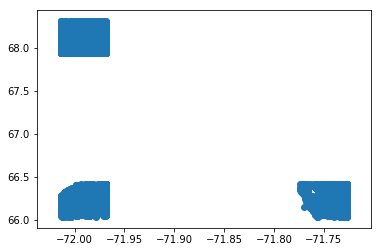

In [99]:
plt.scatter(Centroidlat_total,Centroidlon_total)

In [106]:
len(lon)

12500